# WORKSHOP 2

------------

**<u>GRUPO 4<u>**

Digital House

link git hub: https://github.com/grupo4dhds/grupo4_git.git

--------------

## CONTENIDO


**items celda 4:**
	
	- 1. LECTURA DEL DATASET


	- 2. PRIMER MODULO
    
    * Chequeo de informacion
        * Eliminacion place_name = Capital Federal, state_name == place_name == 'Capital Federal', not relevant
        * Eliminacion de datos nulos en superficie
        * Seleccion de la muestra: mask_muetra
    * Obtencion de la muestra
        * Creacion muestra: data_nuevo
        * Verificacion inicial con statmodels

	- 3. SEGUNDO MODULO
 
    * Definimos el modelo, definimos el feature y el vector prediccion, hacemos la separacion de la muestra de entrenamiento y la de testeo, entrenamiento del modelo, colocacion de etiquetas: Creacion vector prediccion: ypred
    * Evaluacion de la performance, MAE, MSE, RMSE, R2
    * cross_val_score()
    * Segundo modelo:

    - Reacondicionamiento del dataset: data_nuevo_surface_covered
    - Creacion de feature y vector prediccion, creacion del modelo(linreg), entrenamiento algoritmo:
        - modelo de toda la muestra: est
        - modelo de la muestra de entrenamiento: linreg
    - cross_validation(): medidas estadisticas: media y std



In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data_workshop_2.csv')


warnings.filterwarnings('ignore')
data.head(2)

,Unnamed: 0,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,rooms,expenses,above_mean,above_median
0,0,PH,Mataderos,Capital Federal,62000.0,USD,55.0,40.0,1127.272727,Mataderos,NaN,NaN,NaN,NaN,NaN
1,16,PH,Mataderos,Capital Federal,239000.0,USD,140.0,98.0,1707.142857,Mataderos,NaN,4.0,NaN,NaN,NaN


In [3]:
data.shape

(21434, 15)

In [4]:
data.property_type.value_counts()

apartment    15942
house         2583
PH            2212
store          697
Name: property_type, dtype: int64

------------------
**Primer modelo**

* Chequeo de informacion
* Eliminacion place_name = Capital Federal, state_name == place_name == 'Capital Federal', not relevant
* Eliminacion de datos nulos en superficie
* Seleccion de la muestra: mask_muestra

**Obtencion de la muestra**

* Creacion muestra: data_nuevo

In [5]:
data.columns

Index(['Unnamed: 0', 'property_type', 'place_name', 'state_name', 'price',
       'currency', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'place_name_2', 'floor', 'rooms', 'expenses',
       'above_mean', 'above_median'],
      dtype='object')

In [6]:
print(data.shape)
data_dropna_surface_total=data.dropna(subset=['surface_total_in_m2'])
data_dropna_surface_total.state_name.value_counts()

(21434, 15)


Capital Federal                 9984
Bs.As. G.B.A. Zona Norte        2622
Bs.As. G.B.A. Zona Sur          1879
Bs.As. G.B.A. Zona Oeste        1128
Buenos Aires Costa Atlántica     941
Name: state_name, dtype: int64

In [7]:
mask1=data_dropna_surface_total.state_name == 'Capital Federal'
#mask2=data_dropna_surface_total.property_type == 'apartment' 
#mask3=data_dropna_surface_total.property_type =='store'
data_dropna_surface_total.loc[mask1,:].place_name.value_counts()[0:5]

Palermo         1315
Villa Crespo     913
Flores           877
Recoleta         742
Barrio Norte     665
Name: place_name, dtype: int64

In [8]:
mask31=data_dropna_surface_total.place_name =='Palermo'
mask32=data_dropna_surface_total.place_name =='Palermo Hollywood'
mask33=data_dropna_surface_total.place_name =='Palermo Soho'
mask34=data_dropna_surface_total.place_name =='Palermo Chico'
mask41=data_dropna_surface_total.place_name =='Recoleta'
mask42=data_dropna_surface_total.place_name =='Barrio Norte'
mask43=data_dropna_surface_total.place_name =='Retiro'

mask_muestra = ['Palermo', 'Palermo Hollywood', 'Palermo Soho', 'Palermo Chico', 'Recoleta', 'Barrio Norte', 'Retiro']


data_nuevo=data_dropna_surface_total.loc[(mask31 | mask32 | mask33 | mask34 | mask41 | mask42 | mask43),:]

distribucion_data_nuevo=data_nuevo.place_name.value_counts().sum()
print(distribucion_data_nuevo)
data_nuevo.property_type.value_counts()

3485


apartment    3374
store          82
PH             22
house           7
Name: property_type, dtype: int64

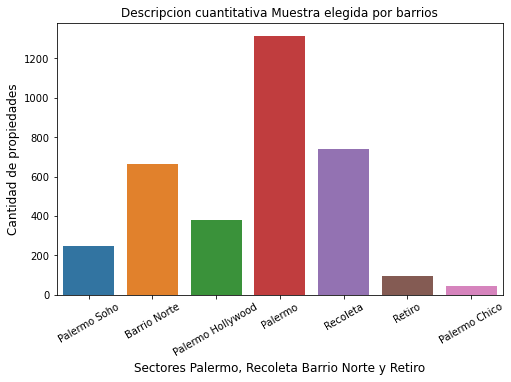

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x='place_name',data=data_nuevo)
plt.xticks(rotation=30)
ax = plt.axes()
ax.set_xlabel('Sectores Palermo, Recoleta Barrio Norte y Retiro', fontsize=12)
ax.set_ylabel('Cantidad de propiedades',fontsize=12);
plt.title('Descripcion cuantitativa Muestra elegida por barrios');

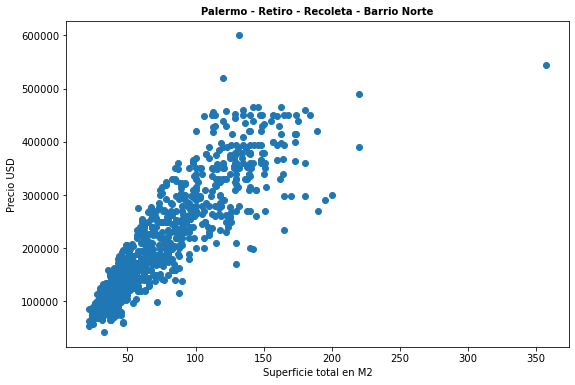

In [10]:
fig = plt.figure(figsize=(9,6))
# creo los axes
ax = plt.axes()
# dibujo en axes:

def get_sample(data, n_sample, replace=False):
    # SUPONE QUE NO HAY REPOSICION COMO DEFAULT
    random_generator = np.random.default_rng()
    index_sample = random_generator.choice(data.index, size = n_sample, replace=replace)
    data_sample = data.loc[index_sample]
    return data_sample

"""
Tener un diccionario que almacene muestra, en este caso uno le dice el numero de muestras y luego contando a partir de 1 en adelante un diccionario te guarda en los keys Muestra_A.keys(): 'muestra_1', 'muestra_2', 'muestra_3'
"""
data_nuevo_sample = get_sample(data_nuevo, 1000, replace=False)

plt.scatter(data_nuevo_sample.surface_total_in_m2,data_nuevo_sample.price)
plt.title('Palermo - Retiro - Recoleta - Barrio Norte',fontweight='bold',size=10)
plt.ylabel('Precio USD')
plt.xlabel('Superficie total en M2')
plt.show()


def identificar_valores_extremos():
    pass

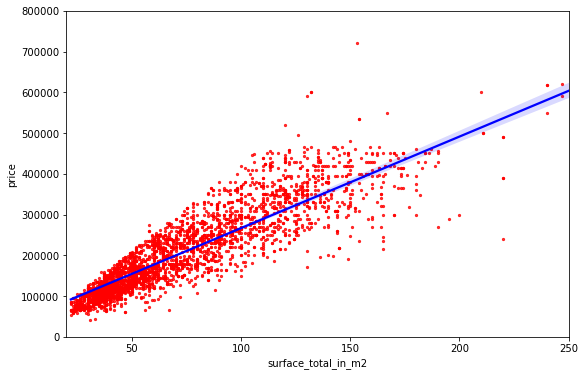

In [11]:
fig = plt.figure(figsize=(9,6))
sns.regplot(data = data_nuevo, x = "surface_total_in_m2", y = "price", 
            ci = 90,
            scatter_kws = {"color": "red", 's': 5},
            line_kws = {"color": "blue"});
plt.xlim(20,250)
plt.ylim(bottom=0,top=.8e6);

**VERIFICACION INICIAL**

In [12]:
# STAT MODELS

X_t = np.array(data_nuevo.surface_total_in_m2, ndmin=2)
X = np.transpose(X_t)
y = data_nuevo.price

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                 1.189e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:28:11   Log-Likelihood:                -42586.
No. Observations:                3485   AIC:                         8.518e+04
Df Residuals:                    3483   BIC:                         8.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.252e+04   1704.045     24.952      0.0

---------------------------------
**modulo 2**

* Definimos el modelo, definimos el feature y el vector prediccion, hacemos la separacion de la muestra de entrenamiento y la de testeo, entrenamiento del modelo, colocacion de etiquetas: Creacion vector prediccion: ypred
* Evaluacion de la performance, MAE, MSE, RMSE, R2
* cross_val_score()
* Segundo modelo:

    - Reacondicionamiento del dataset: data_nuevo_surface_covered
    - Creacion de feature y vector prediccion, creacion del modelo(linreg), entrenamiento algoritmo:
        - modelo de toda la muestra: est
        - modelo de la muestra de entrenamiento: linreg
    - cross_validation(): medidas estadisticas: media y std

In [13]:
model = LinearRegression(fit_intercept=True)
feature_cols = ['surface_total_in_m2']
X=data_nuevo[feature_cols]
y = data_nuevo.price

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtrain)

In [14]:
print ('MAE:', mean_absolute_error(ytrain, ypred).round(2))
print ('MSE:', mean_squared_error(ytrain, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytrain, ypred)).round(2))
print ('R2:', r2_score(ytrain, ypred).round(2))
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=LinearRegression(), X=Xtrain, y=ytrain, cv=3).mean()

MAE: 35005.19
MSE: 2427390123.51
RMSE: 49268.55
R2: 0.78


0.7734395929401942

In [15]:
cross_val_score(estimator=LinearRegression(), X=Xtrain, y=ytrain, cv=3).std()

0.024425873238147305

**Segundo modelo: Data Palermo con superficie cubierta y descubierta**

In [16]:
data_nuevo['surface_covered_in_m2'].isna().sum()
data_nuevo_surface_covered=data_nuevo.dropna(subset=['surface_covered_in_m2'])

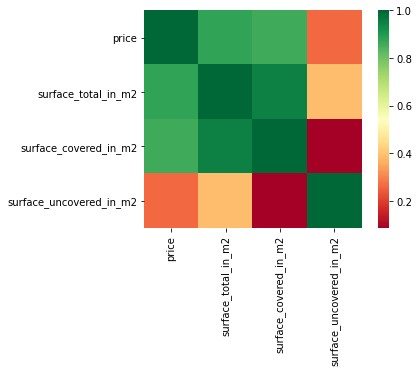

In [17]:
data_nuevo_surface_covered['surface_uncovered_in_m2']=data_nuevo_surface_covered['surface_total_in_m2']-data_nuevo_surface_covered['surface_covered_in_m2']
data_nuevo_surface_covered_heat=data_nuevo_surface_covered[['price','surface_total_in_m2','surface_covered_in_m2','surface_uncovered_in_m2']]
sns.heatmap(data_nuevo_surface_covered_heat.corr(),square=True,cmap='RdYlGn');

In [18]:
feature_cols = ['surface_covered_in_m2','surface_uncovered_in_m2']
X = data_nuevo_surface_covered[feature_cols]
y = data_nuevo_surface_covered.price

linreg = LinearRegression()
est=linreg.fit(X, y) 

# Imprimimos coeficientes
print (linreg.intercept_)
list(zip(feature_cols, linreg.coef_))

43291.62084029624


[('surface_covered_in_m2', 2308.465668756581),
 ('surface_uncovered_in_m2', 1556.3296518807995)]

In [19]:
est.intercept_

43291.62084029624

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3,shuffle=False)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_train).round(2)

In [21]:
print ('MAE:', mean_absolute_error(y_train, y_pred).round(2))
print ('MSE:', mean_squared_error(y_train, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred)).round(2))
print ('R2:', r2_score(y_train, y_pred).round(2))

MAE: 30262.28
MSE: 1661673507.38
RMSE: 40763.63
R2: 0.81


In [22]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=3).mean()

0.7991749220849452

In [23]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=3).std()

0.012948616685818684

**ANALISIS POR STATMODELS**

In [24]:
feature_cols=['surface_covered_in_m2','surface_uncovered_in_m2']
X=data_nuevo_surface_covered[feature_cols]
y= data_nuevo_surface_covered.price
X= sm.add_constant(X)
model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     5828.
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:28:12   Log-Likelihood:                -40088.
No. Observations:                3287   AIC:                         8.018e+04
Df Residuals:                    3284   BIC:                         8.020e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4

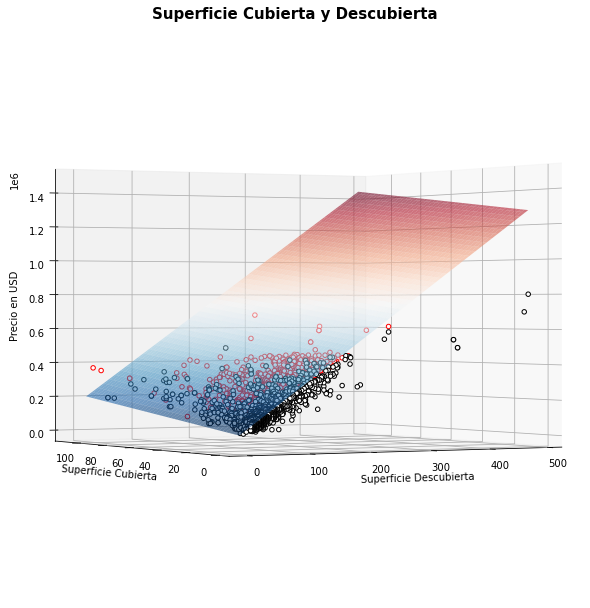

In [25]:
surf_cov, surf_uncov=np.meshgrid(np.linspace(data_nuevo_surface_covered.surface_covered_in_m2.min(),data_nuevo_surface_covered.surface_covered_in_m2.max(),100),np.linspace(data_nuevo_surface_covered.surface_uncovered_in_m2.min(),data_nuevo_surface_covered.surface_uncovered_in_m2.max(),100))
Z=linreg.coef_[0]*surf_cov+linreg.coef_[1]*surf_uncov+linreg.intercept_
fig=plt.figure(figsize=(12,8))
from mpl_toolkits.mplot3d import Axes3D
ax=Axes3D(fig, azim=-120,elev=0)
surf=ax.plot_surface(surf_cov,surf_uncov,Z,cmap=plt.cm.RdBu_r,alpha=0.6)
resid=y-model.predict(X)
ax.scatter(X[resid>=0].surface_covered_in_m2,X[resid>=0].surface_uncovered_in_m2,y[resid>=0], color='red',alpha=1.0,facecolor='white')
ax.scatter(X[resid<0].surface_covered_in_m2,X[resid<0].surface_uncovered_in_m2,y[resid<0], color='black',alpha=1.0,facecolor='white')
ax.set_title('Superficie Cubierta y Descubierta',fontweight='bold',size=15)
ax.set_zlabel('Precio en USD')
ax.set_ylabel('Superficie Cubierta')
ax.set_xlabel('Superficie Descubierta');

**REGULARIZACION**

**Segundo modelo: Data Palermo con superficie cubierta y descubierta con regularizacion Ridge**

In [26]:
scaler = StandardScaler()
print(X.surface_covered_in_m2.mean(),X.surface_covered_in_m2.std())
print(X.surface_uncovered_in_m2.mean(),X.surface_uncovered_in_m2.std())
X_std = scaler.fit_transform(X)

64.25768177669607 37.44946175985987
8.095223608153331 12.53697143542111


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 3)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print(model_fit_ridge_cv.alpha_)
print(model_fit_ridge_cv.best_score_)

1.5
0.7684847986446954


In [28]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)

In [29]:
model_fit_ridge.score(X_test, y_test)
y_pred = model_fit_ridge.predict(X_test)

In [30]:
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('Best alpha:',best_alpha)
print(cross_val_score(estimator=linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False), X=X_train, y=y_train, cv=3).mean())

MAE: 33371.41
MSE: 2003323929.24
RMSE: 44758.51
R2: 0.8
Best alpha: 1.5
0.7668562808431121


**Modelo de regresion con dummies**

In [31]:
data_nuevo_dummies=pd.get_dummies(data_nuevo, columns=['place_name'],prefix="sector")
        

In [32]:
data_nuevo_dummies.head()

,Unnamed: 0,property_type,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,...,expenses,above_mean,above_median,sector_Barrio Norte,sector_Palermo,sector_Palermo Chico,sector_Palermo Hollywood,sector_Palermo Soho,sector_Recoleta,sector_Retiro
95,38422,PH,Capital Federal,160000.0,USD,59.0,59.0,2711.864407,Palermo Soho,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,0
96,56252,PH,Capital Federal,299000.0,USD,165.0,80.0,1812.121212,Palermo Soho,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,0
97,59396,PH,Capital Federal,218000.0,USD,90.0,85.0,2422.222222,Palermo Soho,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,0
98,99424,PH,Capital Federal,420000.0,USD,189.0,NaN,2222.222222,Palermo Soho,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,0
99,107156,PH,Capital Federal,120000.0,USD,45.0,NaN,2666.666667,Palermo Soho,NaN,...,1000.0,NaN,NaN,0,0,0,0,1,0,0


In [33]:
data_nuevo_dummies.shape[0]

3485

In [34]:
feature_cols = ['surface_total_in_m2', 'sector_Palermo','sector_Palermo Chico', 'sector_Palermo Hollywood', 'sector_Palermo Soho','sector_Recoleta','sector_Retiro']
X = data_nuevo_dummies[feature_cols]
y = data_nuevo_dummies.price
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X, y)
print (linreg.intercept_)

Coef_Dummies=pd.Series(list(zip(feature_cols, linreg.coef_)))
type(Coef_Dummies)
print(feature_cols)
print(linreg.coef_)

36386.70424260179
['surface_total_in_m2', 'sector_Palermo', 'sector_Palermo Chico', 'sector_Palermo Hollywood', 'sector_Palermo Soho', 'sector_Recoleta', 'sector_Retiro']
[  2235.37802247   8145.26261564  42302.17734857   5117.14349481
  -4908.35017777  15870.30058005 -15349.98976319]


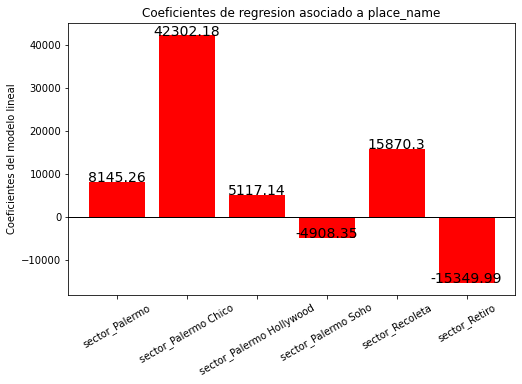

In [35]:
fig, ax=plt.subplots(figsize=(8,5))
barras=ax.bar(feature_cols[1:7],linreg.coef_[1:7].round(2), color='red')
ax.axhline(0, color='black',linewidth=1)
ax.set_ylabel('Coeficientes del modelo lineal')
plt.xticks(rotation=30);
plt.title('Coeficientes de regresion asociado a place_name')

for barra in barras:
    x=barra.get_x()
    y=barra.get_height()
    ancho=barra.get_width()
    if y>0:
        plt.text(x+ancho/2,y+1,round(y,2),fontsize=14,color='black',ha='center',size=14)
    else:
        plt.text(x+ancho/2,y-10,round(y,2),fontsize=14,color='black',ha='center',size=14)
    

In [36]:
X = X
y = data_nuevo_dummies.price

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, shuffle=False)
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_train)

In [38]:
print ('MAE:', mean_absolute_error(y_train, y_pred).round(2))
print ('MSE:', mean_squared_error(y_train, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred)).round(2))
print ('R2:', r2_score(y_train, y_pred).round(2))

MAE: 30816.45
MSE: 1767872389.57
RMSE: 42046.07
R2: 0.8


In [39]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=4).mean()

0.7245177151740574

In [40]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=4).std()

0.10906688850616832

In [41]:
X

,surface_total_in_m2,sector_Palermo,sector_Palermo Chico,sector_Palermo Hollywood,sector_Palermo Soho,sector_Recoleta,sector_Retiro
95,59.0,0,0,0,1,0,0
96,165.0,0,0,0,1,0,0
97,90.0,0,0,0,1,0,0
98,189.0,0,0,0,1,0,0
99,45.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
20997,35.0,0,0,1,0,0,0
20998,200.0,0,0,1,0,0,0
20999,132.0,0,0,1,0,0,0
21000,132.0,0,0,1,0,0,0


In [42]:
arranque = 'surface_total_in_m2'
for i in range(len(X.columns)):
    lista_aux = list(X.columns)
    
    if list(X.columns)[i] == arranque:
        lista_featur_end = (list(X.columns)[i:])
        
lista_featur_end

['surface_total_in_m2',
 'sector_Palermo',
 'sector_Palermo Chico',
 'sector_Palermo Hollywood',
 'sector_Palermo Soho',
 'sector_Recoleta',
 'sector_Retiro']

In [43]:
feature_cols = ['surface_total_in_m2', 'sector_Palermo','sector_Palermo Chico', 'sector_Palermo Soho','sector_Palermo Hollywood','sector_Recoleta','sector_Retiro']


X = X_train[feature_cols]
y = y_train
X= sm.add_constant(X)
model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2060.
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:28:13   Log-Likelihood:                -31527.
No. Observations:                2613   AIC:                         6.307e+04
Df Residuals:                    2607   BIC:                         6.310e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

En virtud de los resultados anteriores y segun el p-value asociado a Sector Palermo Soho y Retiro, replanteo modelo sin esas columna de dummies, resolviendo de esta forma el problema que advierte Satsmodels

In [44]:
feature_cols = ['surface_total_in_m2', 'sector_Palermo','sector_Palermo Hollywood','sector_Recoleta']


X = X_train[feature_cols]
y = y_train
X= sm.add_constant(X)
model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2575.
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:28:13   Log-Likelihood:                -31527.
No. Observations:                2613   AIC:                         6.306e+04
Df Residuals:                    2608   BIC:                         6.309e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   